In [47]:
import json
from sklearn.metrics import roc_auc_score
from netcal.metrics import ECE
import numpy as np
from llm.models import *
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [2]:
with open("data/responses2.json", 'r') as json_file:
        data = json.load(json_file)

In [3]:
first_answers = []
first_confs = []
second_answers = []
second_confs = []
correct_answers = []
for d in data:
  try:
    first_answer, first_conf = d["first_answer"].strip().split(",")
    second_answer, second_conf = d["second_answer"].strip().split(",")
    first_answer, first_conf = int(first_answer.strip()), float(first_conf.strip())
    second_answer, second_conf = int(second_answer.strip()), float(second_conf.strip())
    answer = int(d["answer"])
    first_answers.append(first_answer)
    first_confs.append(first_conf)
    second_answers.append(second_answer)
    second_confs.append(second_conf)
    correct_answers.append(answer)
  except:
    continue

In [4]:
changed = 0
conf_increase = 0
correct_first = 0
correct_second = 0
preds = []
labels = []
confidences = []
predictions = []
real_labels = []
for first_answer, first_conf, second_answer, second_conf, correct in zip(first_answers, first_confs, second_answers, second_confs, correct_answers):
  if first_answer == correct:
    correct_first+=1
    preds.append(1)
  elif second_answer == correct:
    correct_second+=1
    preds.append(0)
  else:
    preds.append(0)
  if first_answer != second_answer:
    changed += 1
  if first_conf < second_conf:
    conf_increase += 1
  if first_conf >= 50:
    labels.append(1)
  else:
    labels.append(0)
  confidences.append(first_conf)
  predictions.append(first_answer)
  real_labels.append(correct)


In [7]:
len(correct_answers), changed, conf_increase, correct_first, correct_second

(671, 501, 97, 271, 54)

In [31]:
roc_auc_score(labels, preds)

0.5783383915022762

In [2]:
def cosine_similarity(A, B):
    A = A[0,:,:]
    B = B[0,:,:]

    if A.shape[0] < B.shape[0]:
        A = np.vstack((A, np.ones((B.shape[0] - A.shape[0], A.shape[1]))))
    elif B.shape[0] < A.shape[0]:
        B = np.vstack((B, np.ones((A.shape[0] - B.shape[0], B.shape[1]))))

    dot_product = np.sum(A * B, axis=0)

    # Compute magnitudes
    magnitude_A = np.sqrt(np.sum(A * A, axis=0))
    magnitude_B = np.sqrt(np.sum(B * B, axis=0))

    # Compute cosine similarity
    cosine_sim = np.mean(dot_product / (magnitude_A * magnitude_B))
    return cosine_sim

## Baseline Score

In [80]:
with open("data/responses2.json", 'r') as json_file:
  data = json.load(json_file)

In [81]:
first_answers = []
correct_answers = []
confs = []
for d in data:
  try:
    first_answer, first_conf = d["first_answer"].strip().split(",")
    first_answer, first_conf = int(first_answer.strip()), float(first_conf.strip())
    answer = int(d["answer"])
    first_answers.append(first_answer)
    correct_answers.append(answer)
    confs.append(first_conf)
  except:
    continue

In [82]:
preds = []
labels = []
predictions = []
real_labels = []
for first_answer, correct, conf in zip(first_answers, correct_answers, confs):
  preds.append(conf)
  if first_answer == correct:
    labels.append(1)
  else:
    labels.append(0)
  predictions.append(first_answer)
  real_labels.append(correct)

In [83]:
roc_auc_score(labels, preds)

0.5686095291663738

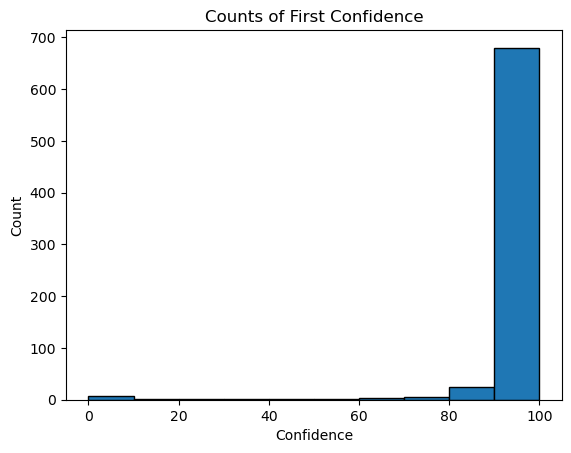

In [84]:
plt.hist(preds, bins=10, range=(0, 100), edgecolor='black')

plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Counts of First Confidence')
plt.show()

In [85]:
n_bins = 10
# diagram = ReliabilityDiagram(n_bins)
ece = ECE(n_bins)
ece_score = ece.measure(np.array(labels, dtype=float), np.array(preds,dtype=float))
print("ECE:", ece_score)

ECE: 0.4107142857142855


## Multiquestion Score

In [74]:
with open("data/multiquestionresponses.json", 'r') as json_file:
  data = json.load(json_file)

In [75]:
first_answers = []
correct_answers = []
avg_sim = []
for d in data:
  try:
    first_answer, first_conf = d["first_answer"].strip().split(",")
    first_answer = int(first_answer.strip())
    answer = int(d["answer"])
    first_answers.append(first_answer)
    correct_answers.append(answer)
    avg_sim.append(float(d["avg_sim"]))
  except:
    continue

In [76]:
preds = []
labels = []
predictions = []
real_labels = []
for first_answer, correct, avg_sim in zip(first_answers, correct_answers, avg_sim):
  if not math.isnan(avg_sim):
    preds.append(avg_sim)
    if first_answer == correct:
      labels.append(1)
    else:
      labels.append(0)
    predictions.append(first_answer)
    real_labels.append(correct)

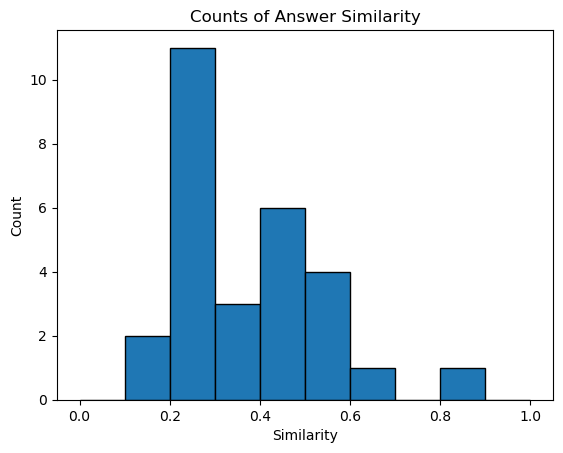

In [77]:
plt.hist(preds, bins=10, range=(0, 1), edgecolor='black')

plt.xlabel('Similarity')
plt.ylabel('Count')
plt.title('Counts of Answer Similarity')
plt.show()

In [78]:
roc_auc_score(labels, preds)

0.4444444444444444

In [79]:
n_bins = 10
# diagram = ReliabilityDiagram(n_bins)
ece = ECE(n_bins)
ece_score = ece.measure(np.array(labels, dtype=float), np.array(preds,dtype=float))
print("ECE:", ece_score)

ECE: 0.6428571428571429


## Second Answer

In [57]:
with open("data/responses2.json", 'r') as json_file:
  data = json.load(json_file)

In [68]:
first_answers = []
second_answers = []
first_confs = []
second_confs = []
correct_answers = []
for d in data:
  try:
    first_answer, first_conf = d["first_answer"].strip().split(",")
    second_answer, second_conf = d["second_answer"].strip().split(",")
    first_answer, first_conf = int(first_answer.strip()), float(first_conf.strip())
    second_answer, second_conf = int(second_answer.strip()), float(second_conf.strip())
    answer = int(d["answer"])
    first_answers.append(first_answer)
    second_answers.append(second_answer)
    first_confs.append(first_conf)
    second_confs.append(second_conf)
    correct_answers.append(answer)
    correct_answers.append(answer)
  except:
    continue

In [69]:
preds = []
labels = []
predictions = []
real_labels = []
for second_answer, correct, conf in zip(second_answers, correct_answers, second_confs):
  preds.append(conf)
  if second_answer == correct:
    labels.append(1)
  else:
    labels.append(0)
  predictions.append(second_answer)
  real_labels.append(correct)

In [70]:
np.mean(preds)

59.03576751117735

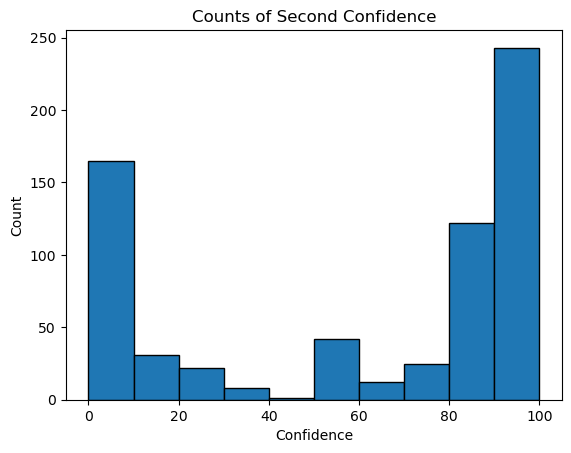

In [71]:
plt.hist(preds, bins=10, range=(0, 100), edgecolor='black')

plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Counts of Second Confidence')
plt.show()

In [72]:
roc_auc_score(labels, preds)

0.40980827682955345

In [73]:
n_bins = 10
# diagram = ReliabilityDiagram(n_bins)
ece = ECE(n_bins)
ece_score = ece.measure(np.array(labels, dtype=float), np.array(preds,dtype=float))
print("ECE:", ece_score)

ECE: 0.21609538002980605


In [64]:
preds = []
labels = []
predictions = []
real_labels = []
for first_answer, second_answer, correct, first_conf, second_conf in zip(first_answers, second_answers, correct_answers, first_confs, second_confs):
  if first_answer == second_answer == correct:
    preds.append(first_conf)
    labels.append(1)
  elif first_answer == second_answer:
    preds.append(first_conf)
    labels.append(0)
  else:
    preds.append(second_conf)
    labels.append(0)
  predictions.append(second_answer)
  real_labels.append(correct)

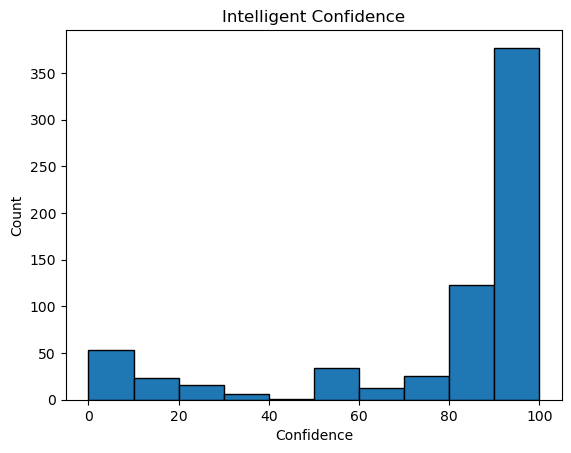

In [65]:
plt.hist(preds, bins=10, range=(0, 100), edgecolor='black')

plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Intelligent Confidence')
plt.show()

In [66]:
roc_auc_score(labels, preds)

0.7770270270270271

In [67]:
n_bins = 10
# diagram = ReliabilityDiagram(n_bins)
ece = ECE(n_bins)
ece_score = ece.measure(np.array(labels, dtype=float), np.array(preds,dtype=float))
print("ECE:", ece_score)

ECE: 0.06110283159463465


## Classification Based

In [3]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff
class Network(torch.nn.Module):

    def __init__(self, input_size, output_size):

        super(Network, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.SiLU(),
            torch.nn.Dropout(.3),

            torch.nn.Linear(2048, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.SiLU(),
            torch.nn.Dropout(.3),

            torch.nn.Linear(2048, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.SiLU(),
            torch.nn.Dropout(.3),

            torch.nn.Linear(1024, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.SiLU(),
            torch.nn.Dropout(.3),

            torch.nn.Linear(1024, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.SiLU(),
            torch.nn.Dropout(.1),

            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.SiLU(),
            torch.nn.Dropout(.1),

            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.SiLU(),
            torch.nn.Dropout(.1),

            torch.nn.Linear(512, output_size)
        )


    def forward(self, x):
        out = self.model(x)

        return out

In [47]:
class AnswerDataset(torch.utils.data.Dataset):
    def __init__(self, data, max_tokens = 250):
      self.states = []
      self.labels = []
      self.length = 0
      model = Mistral()

      for d in data:
        try:
          first_answer, explanation = d["first_answer"].strip().split(",")
          first_answer = int(first_answer.strip())
          answer = int(d["answer"])
          response = model.get_hidden(explanation).cpu().numpy()
          response = response[0,:,:]
          if response.shape[0] < max_tokens:
            response = np.vstack((response, np.ones((250 - response.shape[0], response.shape[1]))))
          elif response.shape[0] > max_tokens:
            response = response[:max_tokens,:]
        
          self.states.append(np.reshape(response, -1))
          if first_answer == answer:
            self.labels.append(1)
          else:
            self.labels.append(0)
        except:
          continue

      self.length = len(self.states)
      # iterate through data and make things

    def __len__(self):
      return self.length
    
    def __getitem__(self, ind):

      state = self.states[ind]

      state      = torch.FloatTensor(state) # Convert to tensors
      labels    = torch.tensor(self.labels[ind])

      return state, labels


In [48]:
with open("data/explanationresponses.json", 'r') as json_file:
  data = json.load(json_file)
total = len(data[:500])
train_val = int(total*.9)
test = total - train_val
train = int(train_val*.9)
val = train_val - train

#TODO: Create a dataset object using the AudioDataset class for the training data
train_data = AnswerDataset(data[:train])

# TODO: Create a dataset object using the AudioDataset class for the validation data
val_data = AnswerDataset(data[train:train+val])

# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AnswerDataset(data[train_val:])

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = 8,
    pin_memory  = True,
    # sampler     = sampler
    shuffle     = True
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 2,
    batch_size  = 8,
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = 8,
    pin_memory  = True,
    shuffle     = False
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [62]:
torch.cuda.empty_cache()
gc.collect()

1872

In [64]:
INPUT_SIZE  = 250 * 4096
model = Network(INPUT_SIZE, 2).to("cuda")

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 22.19 GiB total capacity; 15.77 GiB already allocated; 2.19 GiB free; 19.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [59]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=50)

In [66]:
scaler = torch.cuda.amp.grad_scaler.GradScaler()
def train(model, dataloader, optimizer, criterion, scheduler=None):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (state, label) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        ### Move data to device (ideally GPU)
        state      = state.to("cuda")
        label    = label.to("cuda")
        ### Forward Propagation
        with torch.autocast(device_type='cuda'):
            logits  = model(state)
            print(logits)

            ### Loss Calculation
            loss    = criterion(logits, label)

        ### Backward Propagation
        scaler.scale(loss).backward()

        ### Gradient Descent
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == label).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        if scheduler is not None:
            scheduler.step()

        ### Release memory
        del state, label, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    tloss   /= len(dataloader)
    tacc    /= len(dataloader)

    return tloss, tacc

def eval(model, criterion, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (state, label) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        state      = state.to("cuda")
        label    = label.to("cuda")

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(state)
            ### Loss Calculation
            loss    = criterion(logits, label)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == label).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del state, label, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(dataloader)
    vacc    /= len(dataloader)

    return vloss, vacc

In [67]:
best = 10
for epoch in range(50):

    print("\nEpoch {}/{}".format(epoch+1, 50))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, criterion, val_loader)
    scheduler.step()

    if val_acc > best:
        torch.save(model.state_dict(),f'model_save_blah3.pth')
        best = val_acc

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))


Epoch 1/50


Train:   0%|          | 0/19 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELIS

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.91 GiB (GPU 0; 22.19 GiB total capacity; 15.80 GiB already allocated; 2.19 GiB free; 19.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF